<a href="https://colab.research.google.com/github/anuga-community/anuga-clinic/blob/master/notebooks/notebook1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANUGA Clinic

## Notebook 1: Introduction to ANUGA

Here we introduce the idea of creating a `domain` which contains the mesh and quantities needed to run the simulation, and encapsulates the methods for setting up the initial conditions, the boundary conditions and the method for evolving the solution. 

These notebooks have been designed to run in the google `colaboratory` environment, which provides a jupyter notebook environment running on a virtual machine on the cloud. To use this environment you need a google account so that your notebook can be saved on google drive. 

To start interacting with the notebook follow the 
`View in Colaboratory` link above. 

## Setup Environment

If on github, first follow the link `View in Colaboratory' to start running on google's colab environment. Then ....

Run the following cell to install the dependencies and some extra code for visualising on Colaboratory.

Wait until you see the comment *(4) Ready to go* before proceeding to subsequent commands. 

The install should take less than a minute (and quicker if you have already run this earlier).

In [0]:
try:
  # On colab we can install all the packages we need via the notebook
  #
  # First download the clinic repository
  import os
  os.chdir('/content')
  !git clone https://github.com/anuga-community/anuga-clinic.git

  # Now install environment using tool
  !/bin/bash /content/anuga-clinic/anuga_tools/install_anuga_colab.sh
 
except:
  pass

# Make anuga-clinic code available

if not 'workbookDir' in globals():
    workbookDir = os.getcwd()

import sys
sys.path.append(os.path.join(workbookDir,"anuga-clinic"))

### Setup inline graphics and animation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#from google.colab import files

%matplotlib inline

# Allow inline jshtml animations
from matplotlib import rc
rc('animation', html='jshtml')

## Import ANUGA

Allows us access to `anuga` and inline plotting. 

In [3]:
import anuga

# Create an ANUGA domain

A `domain` is the core object which contains the mesh and the quantities for the particular problem. Here we create a simple rectangular domain. We set the name to `channel1` which will be used when storing the simulation output to a `sww` file called `channel1.sww`.

In [4]:
domain1 = anuga.rectangular_cross_domain(40, 20, len1=20.0, len2=10.0)

domain1.set_name('domain1')
domain1.set_store_vertices_smoothly(False)

## Plot Mesh

Let's look at the mesh. We will use some code derived form the `clawpack` project to simply plot and animate the output from our simulations. This is available via the `animate` module loaded from `anuga`.

The `Domain_plotter` class provides a plotting wrapper around our standard `anuga` `domain`, providing simple access to the centroid values of our evolution quantities, `stage`, `depth`, `elev`, `xmon` and `ymon` and the triangulation `triang`.


Figure files for each frame will be stored in _plot


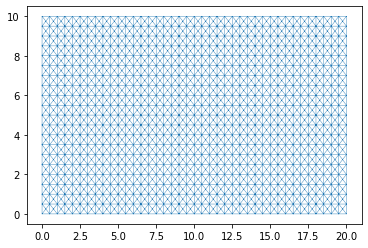

In [5]:
dplotter1 = anuga.Domain_plotter(domain1)  
plt.triplot(dplotter1.triang, linewidth = 0.4);

## Setup Initial Conditions

We have to setup the values of various quantities associated with the domain. In particular we need to setup the `elevation` the elevation of the bed or the bathymetry. In this case we will do this using a function. 

In [6]:
def topography(x, y):

    z = -x/10

    N = len(x)
    
    minx = np.floor(np.max(x)/4)
    wallx1 = np.min(x[(x >= minx)])
    wallx2 = np.min(x[(x > wallx1 + 0.25)])
    
    minx = np.floor(np.max(x)/2)
    wallx3 = np.min(x[(x >= minx)])
    wallx4 = np.min(x[(x > wallx3 + 0.25)])
    
    minx = np.floor(3*np.max(x)/4)
    wallx5 = np.min(x[(x >= minx)])
    wallx6 = np.min(x[(x > wallx5 + 0.25)])
    
    dist = 0.4 * (np.max(y) - np.min(y))
    
    for i in range(N):
        if wallx1 <= x[i] <= wallx2:
            if (y[i] < dist):
                z[i] += 1
                
        if wallx3 <= x[i] <= wallx4:
            if (y[i] > np.max(y) - dist):
                z[i] += 1
                
        if wallx5 <= x[i] <= wallx6:
            if (y[i] < dist):
                z[i] += 1
            
    return z

### Set Quantities

Now we set the `elevation`, `stage` and `friction` using the `domain.set_quantity` function. 

In [7]:
domain1.set_quantity('elevation', topography, location='centroids')         # Use function for elevation
domain1.set_quantity('friction', 0.01, location='centroids')                # Constant friction 
domain1.set_quantity('stage', expression='elevation', location='centroids') # Dry Bed 

### View Elevation

Let's use the `matplotlib` function `tripcolor` to plot the `elevation` quantitiy.  We access the `domain` mesh and elevation quantitiy via the `dplotter` interface.  

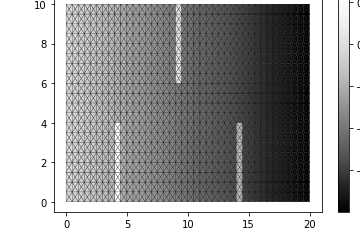

In [8]:
plt.tripcolor(dplotter1.triang, 
              facecolors = dplotter1.elev, 
              edgecolors='k', 
              cmap='Greys_r')
plt.colorbar();

## Setup Boundary Conditions

The rectangular domain has 4 tagged boundaries, left, top, right and bottom. We need to set boundary conditons for each of these tagged boundaries. We can set Dirichlet type BC with specified values of stage, and x and y "momentum". Another common BC is `Reflective_boundary` which mimic a wall. 

In [9]:
Bi = anuga.Dirichlet_boundary([0.4, 0, 0])         # Inflow
Bo = anuga.Dirichlet_boundary([-2, 0, 0])          # Inflow
Br = anuga.Reflective_boundary(domain1)            # Solid reflective wall

domain1.set_boundary({'left': Bi, 'right': Bo, 'top': Br, 'bottom': Br})

## Run the Evolution

We evolve using a `for` statement, which evolves the quantities using the shallow water wave solver. The calculation `yields` every `yieldstep` seconds, for a given `duration`.

In [10]:
for t in domain1.evolve(yieldstep=2, duration=40):
  
    #dplotter.plot_depth_frame()
    dplotter1.save_depth_frame(vmin=0.0,vmax=1.0)
    
    domain1.print_timestepping_statistics()

    
# Read in the png files stored during the evolve loop
dplotter1.make_depth_animation() 

Time = 0.0000, steps=0 (33s)
Time = 2.0000, delta t in [0.01779464, 0.03749219], steps=93 (1s)
Time = 4.0000, delta t in [0.01523410, 0.01780455], steps=123 (1s)
Time = 6.0000, delta t in [0.01509139, 0.01543878], steps=132 (1s)
Time = 8.0000, delta t in [0.01543945, 0.01589701], steps=129 (1s)
Time = 10.0000, delta t in [0.01510457, 0.01595656], steps=129 (1s)
Time = 12.0000, delta t in [0.01448747, 0.01510270], steps=136 (1s)
Time = 14.0000, delta t in [0.01416889, 0.01448641], steps=140 (1s)
Time = 16.0000, delta t in [0.01390842, 0.01416679], steps=143 (1s)
Time = 18.0000, delta t in [0.01381293, 0.01390783], steps=145 (1s)
Time = 20.0000, delta t in [0.01356459, 0.01381284], steps=147 (1s)
Time = 22.0000, delta t in [0.01337491, 0.01356424], steps=149 (1s)
Time = 24.0000, delta t in [0.01312175, 0.01337337], steps=152 (1s)
Time = 26.0000, delta t in [0.01302523, 0.01317617], steps=153 (1s)
Time = 28.0000, delta t in [0.01288636, 0.01302421], steps=155 (1s)
Time = 30.0000, delta t 

### Optional Installation of ANUGA Viewer

On  Windows you might like to download and extract a precompiled version ``anuga_viewer.zip`` from sourceforge https://sourceforge.net/projects/anuga/files/anuga_viewer_windows/

Once extracted, go to the data directory and associate the sww file with the viewer executable in the bin directory. 

Then sww files should always open with the anuga viewer.

### Download Domain 

If you have the ``anuga_viewer`` installed on your local machine you might want to download the output file ``domain1.sww`` to your local disk and view it using the ``anuga_viewer``

I had problems on using the Chrome browser and had to follow the instructions from this site to allow downloads, https://stackoverflow.com/questions/53581023/google-colab-file-download-failed-to-fetch-error

In [0]:
files.download('domain1.sww')

# Alternative Mesh Constructions

`ANUGA` is based on triangles and so  the mesh can conform to interesting geometrical structures. In our example the steps define an interesting geometry. Let's conform our mesh to the steps. 

We will use the construction function  `anuga.create_domain_from_regions`. This function needs at least a polygon which defines the boundary of the region, and a tagging of the sections of the boundry polygon, which will allow us to specify specific boundary conditions associated with the tagged sections of the boundary. 

In our previous example the function `rectangular_cross_doamin` created a mesh with 4 tagged boundary sections, corresponding to the tags  `left`,  `right`, '`top` and `bottom`. 

We wil do the same, but this time using the function `anuga.create_domain_from_regions`.

Figure files for each frame will be stored in _plot


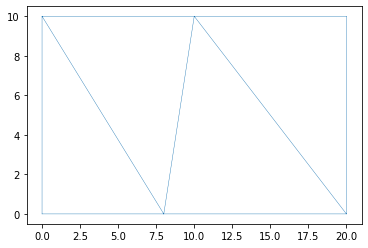

In [11]:
bounding_polygon = [[0.0, 0.0],
                    [20.0, 0.0],
                    [20.0, 10.0],
                    [0.0, 10.0]]

boundary_tags={'bottom': [0],
                'right': [1],
                'top': [2],
                'left': [3]}


domain2 = anuga.create_domain_from_regions(bounding_polygon, boundary_tags)

# Plot the resulting mesh
dplotter2 = anuga.Domain_plotter(domain2)  
plt.triplot(dplotter2.triang, linewidth = 0.4);

### Mesh size

Obviously the mesh is too coarse. We can force the mesh size to be smaller by using the argument `maximum_triangle_size`.

Figure files for each frame will be stored in _plot


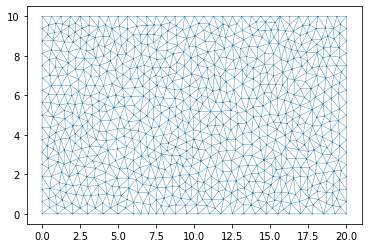

In [12]:
domain2 = anuga.create_domain_from_regions(bounding_polygon,
                               boundary_tags, 
                               maximum_triangle_area = 0.2,
                               )

# Plot the resulting mesh
dplotter2 = anuga.Domain_plotter(domain2)  
plt.triplot(dplotter2.triang, linewidth = 0.4);

### More Complicated Boundary

In the first example we created the steps using a discontinuous elevation. We can mimic that behaviour by explicitly cutting out the triangles associated with the steps. This leads to a more complicated boundary polygon. 

Note that we need to be careful about associating boundary polygon sections with the approriate tagged boundary.

We now have 7 tagged bounday regions. These 7 regions will need to be associated with appropriate boundary conditions. 

Figure files for each frame will be stored in _plot


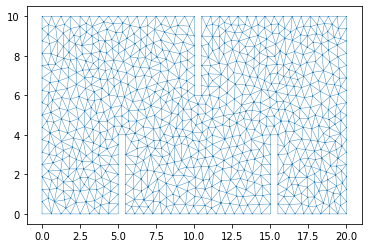

In [13]:
bounding_polygon = [[0.0, 0.0],
                    [5.0, 0.0], [5.0, 4.0], [5.5, 4.0], [5.5, 0.0],
                    [15.0, 0.0], [15.0, 4.0], [15.5, 4.0], [15.5, 0.0],
                    [20.0, 0.0],
                    [20.0, 10.0],
                    [10.5, 10.0], [10.5, 6.0], [10, 6.0], [10, 10.0],
                    [0.0, 10.0]]

boundary_tags={'bottom': [0,4,8],
               'right': [9],
               'top': [10,14],
               'left': [15],
               'wall1': [1,2,3],
               'wall2': [5,6,7],
               'wall3': [11,12,13]
              }


domain2 = anuga.create_domain_from_regions(bounding_polygon, 
                                           boundary_tags,
                                           maximum_triangle_area = 0.2,)

domain2.set_name('domain2')
domain2.set_store_vertices_smoothly(False)

# Plot the resulting mesh
dplotter2 = anuga.Domain_plotter(domain2)  
plt.triplot(dplotter2.triang, linewidth = 0.4);

### Initial Conditions and Boundary Conditions

As before we setup the inital values for our elevation, friction and stage. And associated Dirichlet BC on the left and right boundary regions and reflective everywhere else. 

In [14]:
#Initial Conditions
domain2.set_quantity('elevation', lambda x,y : -x/10, location='centroids')  # Use function for elevation
domain2.set_quantity('friction', 0.01, location='centroids')                # Constant friction 
domain2.set_quantity('stage', expression='elevation', location='centroids') # Dry Bed 

# Boundary Conditions
Bi = anuga.Dirichlet_boundary([0.4, 0, 0])         # Inflow
Bo = anuga.Dirichlet_boundary([-2, 0, 0])          # Inflow
Br = anuga.Reflective_boundary(domain2)            # Solid reflective wall

domain2.set_boundary({'left': Bi, 'right': Bo, 'top': Br, 'bottom': Br, 'wall1': Br, 'wall2': Br, 'wall3': Br})

### Evolve

Now we can evolve. With this implementation the step walls are infinitely high and so we will not get a flow over the top of 2nd lower step. 

In [15]:
for t in domain2.evolve(yieldstep=2, duration=40):
  
    #dplotter.plot_depth_frame()
    dplotter2.save_depth_frame(vmin=0.0, vmax=1.0)
    
    domain2.print_timestepping_statistics()

    
# Read in the png files stored during the evolve loop
dplotter2.make_depth_animation() 

Time = 0.0000, steps=0 (30s)
Time = 2.0000, delta t in [0.01905513, 0.04796679], steps=87 (1s)
Time = 4.0000, delta t in [0.01744624, 0.01945916], steps=109 (0s)
Time = 6.0000, delta t in [0.01382385, 0.01743857], steps=134 (1s)
Time = 8.0000, delta t in [0.01615668, 0.01741694], steps=121 (0s)
Time = 10.0000, delta t in [0.01595034, 0.01723757], steps=123 (1s)
Time = 12.0000, delta t in [0.01510446, 0.01647925], steps=128 (1s)
Time = 14.0000, delta t in [0.01386254, 0.01509676], steps=137 (1s)
Time = 16.0000, delta t in [0.01301787, 0.01385327], steps=151 (1s)
Time = 18.0000, delta t in [0.01246696, 0.01301680], steps=158 (1s)
Time = 20.0000, delta t in [0.01228814, 0.01246448], steps=162 (1s)
Time = 22.0000, delta t in [0.01209191, 0.01229133], steps=165 (1s)
Time = 24.0000, delta t in [0.01206389, 0.01210745], steps=166 (1s)
Time = 26.0000, delta t in [0.01202287, 0.01212743], steps=166 (1s)
Time = 28.0000, delta t in [0.01195973, 0.01202261], steps=167 (1s)
Time = 30.0000, delta t 

### Download to Local Disk
If you have the anuga viewer installed you might want to download the output file domain2.sww to your local disk.

In [0]:
files.download('domain2.sww')

# River Walls

An alternative method to simulate our walls is to use `riverWalls`. Think of  `riverWalls` as infinitely thin walls. To set these up we need to build our mesh with  `breaklines` to define where the wall will occur and also how to apply them during the evolution by setting up a `riverWall` operator. 

First setup the mesh.

We setup a dictionary to contain the x,y,z information of each of the river walls in our simulation. In this case 3 river walls associated with wall1 to wall3. 

Look carefully at the mesh produced and notice the straight lines in the mesh at the location of the walls. 

Figure files for each frame will be stored in _plot


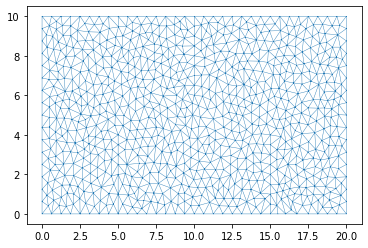

In [16]:
bounding_polygon = [[0.0, 0.0],
                    [20.0, 0.0],
                    [20.0, 10.0],
                    [0.0, 10.0]]

boundary_tags={'bottom': [0],
               'right': [1],
               'top': [2],
               'left': [3]
              }


riverWalls = { 'wall1': [[5.0,0.0,   0.5], [5.0,4.0,  0.5]],
               'wall2': [[15.0,0.0, -0.5], [15.0,4.0,-0.5]],
               'wall3': [[10.0,10.0, 0.0], [10.0,6.0, 0.0]]
             }

#bline = [[[0.1,5.0,0.0],[19.9,5.0,0.0]]]
              
domain3 = anuga.create_domain_from_regions(bounding_polygon, 
                                           boundary_tags,
                                           maximum_triangle_area = 0.2,
                                           breaklines = riverWalls.values())

domain3.set_name('domain3')
domain3.set_store_vertices_smoothly(False)

# Plot the resulting Mesh
dplotter3 = anuga.Domain_plotter(domain3)  
plt.triplot(dplotter3.triang, linewidth = 0.4);

### Initial and Boundary Conditions and River walls

In [17]:
#Initial Conditions
domain3.set_quantity('elevation', lambda x,y : -x/10, location='centroids') # Use function for elevation
domain3.set_quantity('friction', 0.01, location='centroids')                # Constant friction 
domain3.set_quantity('stage', expression='elevation', location='centroids') # Dry Bed 


# Boundary Conditions
Bi = anuga.Dirichlet_boundary([0.4, 0, 0])         # Inflow
Bo = anuga.Dirichlet_boundary([-2, 0, 0])          # Inflow
Br = anuga.Reflective_boundary(domain2)            # Solid reflective wall

domain3.set_boundary({'left': Bi, 'right': Bo, 'top': Br, 'bottom': Br})

# Setup RiverWall
domain3.riverwallData.create_riverwalls(riverWalls, verbose=False)


### Evolve

Notice that we have setup the river walls to be only 1 metre high. So we would expect some overtopping of the 2nd lower step. 

In [18]:
for t in domain3.evolve(yieldstep=2, duration=40):
  
    #dplotter.plot_depth_frame()
    dplotter3.save_depth_frame(vmin=0.0, vmax=1.0)
    
    domain3.print_timestepping_statistics()

    
# Read in the png files stored during the evolve loop
dplotter3.make_depth_animation() 

Time = 0.0000, steps=0 (8s)
Time = 2.0000, delta t in [0.01813369, 0.04322357], steps=86 (1s)
Time = 4.0000, delta t in [0.01584979, 0.01883231], steps=118 (0s)
Time = 6.0000, delta t in [0.01583185, 0.01738707], steps=121 (1s)
Time = 8.0000, delta t in [0.01625105, 0.01686416], steps=122 (0s)
Time = 10.0000, delta t in [0.01662976, 0.01887900], steps=111 (0s)
Time = 12.0000, delta t in [0.01762579, 0.01855303], steps=112 (0s)
Time = 14.0000, delta t in [0.01705865, 0.01766205], steps=116 (0s)
Time = 16.0000, delta t in [0.01673190, 0.01716414], steps=118 (0s)
Time = 18.0000, delta t in [0.01581448, 0.01672762], steps=124 (0s)
Time = 20.0000, delta t in [0.01558134, 0.01581339], steps=128 (0s)
Time = 22.0000, delta t in [0.01517773, 0.01559634], steps=131 (1s)
Time = 24.0000, delta t in [0.01509483, 0.01517755], steps=133 (0s)
Time = 26.0000, delta t in [0.01510280, 0.01513743], steps=133 (0s)
Time = 28.0000, delta t in [0.01495640, 0.01513585], steps=133 (0s)
Time = 30.0000, delta t i

### Download to Local Disk
If you have the anuga viewer installed you might want to download the output file domain3.sww to your local disk.

In [0]:
files.download('domain3.sww')

[Next Notebook](https://colab.research.google.com/github/stoiver/anuga-clinic-2018/blob/master/notebooks/notebook2.ipynb)